In [1]:
from __future__ import unicode_literals, print_function, division
import copy

import numpy as np
import scipy.integrate as integrate

from scipy import constants
from scipy import interpolate

# Plotting
import matplotlib.pyplot as plt
from matplotlib import scale as mscale
from matplotlib.transforms import Transform
from matplotlib.ticker import FixedLocator

_GN_ = constants.gravitational_constant # Meter^3 Kilogram^-1 Second^-2 
_c_light_ = constants.c # Meter Second^-1
_eV_ = constants.eV; # Meter^2 Kilogram Second^-2
_kB_ = constants.Boltzmann # Joule Kelvin^-1
_hP_ = constants.Planck # Joule Second 
_aB_ = 8*np.pi**5*_kB_**4/(15*_hP_**3*_c_light_**3) #Joule Kelvin^-4 Meter-3

#Conversions
_Meter_per_MPc_ = constants.mega*constants.parsec
H_0_std=100 * constants.kilo/_Meter_per_MPc_

In [2]:
Tcmb_pk = 2.7255 # Kelvin 
Nur_pk = 3.046;
h_pk = 0.67556;
omega_b_pk = 0.022032;
omega_cdm_pk = 0.12038;

Omega_b_pk = omega_b_pk/(h_pk**2)
Omega_cdm_pk = omega_cdm_pk/(h_pk**2)

H_0_pk= h_pk* H_0_std
rho_crit_pk= 3* H_0_pk**2 /(8*np.pi*_GN_)


def a_of_z(z,a_0=1.):
    return a_0/(1.+z)

In [3]:

class cosmic_fluid(object):
    """A fluid model for cosmic material
    
        naught values corrispond to today
        
        """
    def p(self,a):
        return self.rho(a) * self.w(a)
 
        
class cosmic_fluid_const_w(cosmic_fluid):
    """A cosmic fluid with constant w(a)"""
    
    def __init__(self,rho_ref,w,a_0=1.,a_ref=1.):
        self.w = lambda a=a_0: w
        self.a_0 = a_0
        self.rho_0 = rho_ref * (a_ref/a_0)**(3*(1+w))
        
    def rho(self,a):
            return self.rho_0*(self.a_0/a)**(3*(1+ self.w()))
    

    
class cosmic_fluid_spline_w(cosmic_fluid):
    """A cosmic fluid with a given spline made with numpy.interpolate.splrep for w(a)"""
    
    def __init__(self,rho_ref,w_splinerep,a_0=1.,a_ref=1.):
        self.w_spline_rep = copy.copy(w_splinerep)
        self.w = lambda a:interpolate.splev(np.log10(a), self.w_spline_rep, der=0)
        self.a_0 = a_0
        self.rho_0 = rho_ref * (a_ref/a_0)**3* 10**(-3*interpolate.splint(np.log10(a_ref),np.log10(a_0),w_gamma_spline_rep))
        
    def rho(self,a):
        return self.rho_0*(self.a_0/a)**3 * 10**(-3*interpolate.splint(np.log10(self.a_0),np.log10(a),w_gamma_spline_rep))
    

In [4]:
#A test of spline vs constant w

def rho_0_gamma(T=Tcmb_pk):
    return _aB_ / _c_light_**2 * T**4

gamma= cosmic_fluid_const_w(rho_0_gamma(),1/3)

def w_gamma(a):
    return 1./3.

log10a_range= np.arange(-14.5,0.5,0.1)
vw=np.vectorize(w_gamma)
vw(log10a_range)
w_gamma_spline_rep=interpolate.splrep(log10a_range, vw(log10a_range), s=0)

gamma= cosmic_fluid_const_w(rho_0_gamma(),1/3)
gamma_spl= cosmic_fluid_spline_w(rho_0_gamma(),w_gamma_spline_rep)
gamma.rho(10**-2)==gamma_spl.rho(10**-2)

True

In [5]:

class composite_fluid(object):
    """ A collection of cosmic fluids with methods to have sum total of properties"""
        
    def __init__(self,fluids,a_0=1):
        self.fluids = copy.copy(fluids)
        self.rho_0  = 0
        self.a_0    = a_0

        for fluid in fluids:
            self.rho_0  += fluid.rho_0
            assert self.a_0 == fluid.a_0,"Uncommon scale factor for today"


    def rho(self,a):
        rho_tot=0
        for fluid in self.fluids:
            rho_tot += fluid.rho(a)
        return rho_tot
    
    def p(self,a):
        p_tot=0
        for fluid in fluids:
            p_tot += fluid.p(a)
        return p_tot
    
    def w(self,a):
        rho_tot=0
        p_tot=0
        for fluid in fluids:
            rho_tot += fluid.rho(a)
            p_tot += fluid.p(a)
        return p_tot/rho_tot 
    
    

        
 

In [29]:
class universe(composite_fluid):
    """ A model of the univsere as a collection of cosmic fluids
                Several optional arguments
                h - If provided a cosmological constant is added to satisfy H_0
                k - Non-functioning
                a_0 - a common scale factor value for today amongst the fluids"""
        
        
    def __init__(self,fluids,h=None,k=0,a_0=1):
        assert k==0, "non-flat conditions have not been coded"        
        self.fluids = copy.copy(fluids)
        
        self.rho_0  = 0
        self.a_0    = a_0
        for fluid in fluids:
            self.rho_0  += fluid.rho_0
            assert self.a_0 == fluid.a_0,"Uncommon scale factor for today"

        if h==None:
            self.rho_crit = self.rho_0
            self.H_0 =((8*np.pi*_GN_)*self.rho_crit/3)**0.5
            self.h = self.H_0/H_0_std
        else:
            self.h=h
            self.H_0= h * H_0_std
            self.rho_crit= 3*(h * H_0_std)**2/(8*np.pi*_GN_)
            if(self.rho_crit- self.rho_0!=0):
                self.dark_energy = cosmic_fluid_const_w(self.rho_crit- self.rho_0, -1,a_0)
                self.fluids= self.fluids+[self.dark_energy]
            

    
    def Omega(self,fluid):
        return fluid.rho_0/self.rho_crit
        
    def omega(self,fluid):
        return fluid.rho_0/self.rho_crit * self.h ** 2 
    
    def rho_tot(self,a):
        sum=0
        for fluid in self.fluids:
            sum += fluid.rho(a)
        return sum    
        

In [28]:
def rho_0_gamma_pk(T=Tcmb_pk):
    return _aB_ / _c_light_**2 * T**4

gamma= cosmic_fluid_const_w(rho_0_gamma_pk(),1/3)

def rho_0_nu_pk(T=Tcmb_pk,Nur=Nur_pk):
    return   rho_0_gamma_pk(T)  *7./8.*(4./11.)**(4./3.)*Nur

nu = cosmic_fluid_const_w(rho_0_nu_pk(),1/3)


def rho_0_b_pk(Omega_b=Omega_b_pk,rho_crit=rho_crit_pk):
    return Omega_b* rho_crit

baryons = cosmic_fluid_const_w(rho_0_b_pk(),0)

def rho_0_cdm_pk(Omega_cdm=Omega_cdm_pk,rho_crit=rho_crit_pk):
    return Omega_cdm* rho_crit

cdm = cosmic_fluid_const_w(rho_0_cdm_pk(),0)

fluids=[gamma,nu,baryons,cdm]

LCDM=universe(fluids,h_pk)

In [8]:
#Test Omega_tot=1
Omega_tot=0
for fluid in LCDM.fluids:

    Omega_tot+=LCDM.Omega(fluid)

Omega_tot==1


True

In [50]:
#USED IN FISHER
rhor3000=gamma.rho(a_of_z(3000))+nu.rho(a_of_z(3000))
rhom3000=baryons.rho(a_of_z(3000))+cdm.rho(a_of_z(3000))
rhor0=gamma.rho(1)+nu.rho(1)
rhom0=baryons.rho(1)+cdm.rho(1)

anchors=np.concatenate(([-15],np.arange(-7,-2),[1]))
vals = np.array([1,0.9,0.3,0,-0.3,-0.9,1])
w_spline_rep=interpolate.splrep(anchors,vals, s=0)
dsg_dict={'dsg_log10a_vals':np.concatenate(([-15],np.arange(-4,-1.9,.5),[1])),
    'dsg_w_vals':np.array([1,0.9,0.3,0,-0.3,-0.9,1]),
    'dsg_alpha' : 0.00001200901405,
    'dsg_c_eff2':1/3.,
    'nap' : 'y',
    'dsg_c_vis2':1/3.}
gdm=cosmic_fluid_spline_w((rhor3000+rhom3000)*0.1,w_spline_rep,a_0=1.,a_ref=a_of_z(3000))
gdm.rho(1)/(rhor0+rhom0)


6.268026419446873e-05

In [52]:
anchors= np.concatenate(([-15],np.arange(-4,-1.9,.5),[1]))
vals = np.zeros(len(np.concatenate(([-15],np.arange(-7,-2),[1]))))
w_dsg_cdm_spline_rep=interpolate.splrep(anchors,vals, s=0)
dsg_dict={'dsg_log10a_vals':np.concatenate(([-15],np.arange(-4,-1.9,.5),[1])),
    'dsg_w_vals':np.zeros(len(np.concatenate(([-15],np.arange(-7,-2),[1])))),
    'dsg_alpha' : 0.00001200901405,
    'dsg_c_eff2':1/3.,
    'nap' : 'y',
    'dsg_c_vis2':1/3.}
gdm=cosmic_fluid_spline_w((rhor3000+rhom3000)*0.1,w_spline_rep,a_0=1.,a_ref=a_of_z(3000))
gdm.rho(1)/(rhor0+rhom0)

6.268026419446873e-05

In [9]:


dsg_log10a_posts=np.array([-15,-5,-4.6,-4.2,-3.8,-3.4,-3,1])
w_dsg_cdm_anchors=np.full(len(dsg_log10a_posts),0)
w_dsg_cdm_spline_rep=interpolate.splrep(dsg_log10a_posts,w_dsg_cdm_anchors, s=0)

a_ref=a_of_z(3000)
cdm_surpressed=  cosmic_fluid_const_w(rho_0_cdm_pk(Omega_cdm=0.9*Omega_cdm_pk),0)
bg=composite_fluid([gamma,nu,baryons,cdm_surpressed])
rho_dsg_cdm_ref=0.1*cdm.rho(a_ref)
dsg = cosmic_fluid_spline_w(rho_dsg_cdm_ref,w_dsg_cdm_spline_rep,a_ref=a_ref)


dsg_cdm_test_uni = universe([gamma,nu,baryons,cdm_surpressed,dsg],)

In [10]:
#Test Omega_tot=1
tol = 1e-15
Omega_tot=0
for fluid in dsg_cdm_test_uni.fluids:

    Omega_tot+=dsg_cdm_test_uni.Omega(fluid)

abs(Omega_tot-1)<tol


True

In [11]:
# CLASS

from classy import Class

In [12]:
# Creates an instance of CLASS
cosmo = Class()
CLASS_INPUT={}
raw_cl={}

In [21]:
def arr_to_str(arr):
    return ','.join([str(num) for num in arr])

In [14]:
cosmo.struct_cleanup()
cosmo.empty()
cosmo.set_default()
cosmo.compute()
raw_cl['default']=cosmo.raw_cl()
cosmo.struct_cleanup()
cosmo.empty()

In [22]:
data_sets_non_def=('dsg_cdm_basic','dsg_cdm_nap','dsg_cdm_vis')

CLASS_INPUT['dsg_cdm_basic']={}
CLASS_INPUT['dsg_cdm_basic']['output']='tCl'
CLASS_INPUT['dsg_cdm_basic']['dsg_alpha']=dsg.rho_0/bg.rho_0
CLASS_INPUT['dsg_cdm_basic']['dsg_log10a_vals']=arr_to_str(dsg_log10a_posts)
CLASS_INPUT['dsg_cdm_basic']['dsg_w_vals']=arr_to_str(w_dsg_cdm_anchors)

CLASS_INPUT['dsg_cdm_nap']=CLASS_INPUT['dsg_cdm_basic']
CLASS_INPUT['dsg_cdm_nap']['nap']='y'
CLASS_INPUT['dsg_cdm_nap']['dsg_c_eff2']=0

CLASS_INPUT['dsg_cdm_vis']=CLASS_INPUT['dsg_cdm_nap']
CLASS_INPUT['dsg_cdm_vis']['dsg_c_vis2']=0

In [23]:
cosmo.struct_cleanup()
cosmo.empty()

for data_set in data_sets_non_def:
    cosmo.set(CLASS_INPUT[data_set])
    cosmo._fillparfile()
    cosmo.compute()
    raw_cl[data_set]=cosmo.raw_cl()
    cosmo.struct_cleanup()
    cosmo.empty()

In [24]:
k_vals=raw_cl['default']['ell'][2:]
cl={}
cl['default']=raw_cl['default']['tt'][2:]
for name in data_sets_non_def:
    cl[name]=raw_cl[name]['tt'][2:]

In [25]:
cl_ratio={}
for name in data_sets_non_def:
    cl_ratio[name]=cl[name]/cl['default']-1

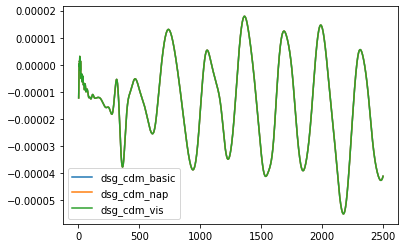

In [26]:
plt.figure(1)
for name in data_sets_non_def:
    plt.plot(k_vals,cl_ratio[name])

plt.legend(data_sets_non_def)

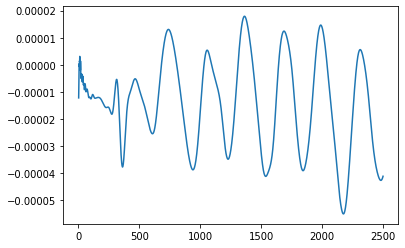

In [27]:
plt.figure(2)
plt.plot(k_vals,cl_ratio['dsg_cdm_basic'])
